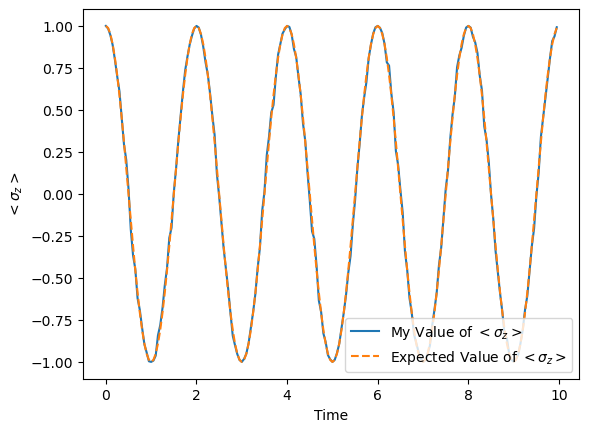

In [5]:
from qiskit import QuantumCircuit, execute, Aer, transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from qiskit_ibm_provider import IBMProvider

# Constants and simulation parameters
N = 4  # Number of qubits
delta_m_squared = 2*pi
E = 1
omegas = np.array([delta_m_squared / (2 * E) for _ in range(N)])  # omega for each qubit

bs = omegas / 2
tolerance = 0.1  # Define your tolerance

# Time parameters
dt = 0.05  # Time step for the simulation
time_steps = 200  # Total number of time steps for the simulation

provider = IBMProvider()
# provider = IBMProvider(instance="ibm-q-ornl/ornl/csc500")

# # Select a backend
# backend = provider.get_backend('simulator_mps')
backend = Aer.get_backend('aer_simulator')
shots = 1024

# Function to create and evolve the circuit for a given time step
def evolve_and_measure_circuit(dt, thetas):
    qc = QuantumCircuit(N, N)
    thetas = 2 * dt * bs   # Calculate the angle for RZ gates
    for i in range(N):
        qc.rx(thetas[i], i)  # Apply RX gate with theta for each qubit
    qc.measure(range(N), range(N)) # measure the quantum register and store it in the classical register  
    return qc

# Simulation and expected value calculation
sigma_z_values = []
expected_sz_array = []

for step in range(time_steps):
    t = dt * step
    expected_sz = []
    thetas = 2 * dt * bs  # Calculate the angle for RX gates for each qubit
    for i in range(N):
        expected_sz.append(np.cos(omegas[i] * t))
    expected_sz_array.append(np.mean(expected_sz) if expected_sz else None)
    
    qc = evolve_and_measure_circuit(t, thetas)
    result = execute(qc, backend, shots=shots).result()
    counts = result.get_counts(qc)
    
    # Calculate expectation value of sigma_z for this step
    sigma_z = 0
    # for outcome in counts:
    #     # Convert the outcome to sigma_z contributions
    #     sigma_z_contribution = sum([1 if bit == '0' else -1 for bit in outcome]) / N
    #     sigma_z += sigma_z_contribution * counts[outcome] / shots
    # sigma_z_values.append(sigma_z)
    for outcome in counts:
    # Convert the outcome to sigma_z contribution for the first qubit
    # Qiskit orders qubits in reverse; qubit 0 is the rightmost bit
        if outcome[::-1][0] == '0':  # Check the state of the first qubit
            sigma_z += counts[outcome] / shots
        else:
            sigma_z -= counts[outcome] / shots
    
    # Store the calculated value
    sigma_z_values.append(sigma_z)
    
# qc = evolve_and_measure_circuit(t, thetas)
# result = execute(qc, backend, shots=shots).result()
# counts = result.get_counts(qc)
# plot_histogram(counts)

# # Verify the condition
# assert all(abs(np.array(sigma_z_values) - np.array(expected_sz_array)) < tolerance), "Assertion failed: values differ more than tolerance"

# Plotting
time_array = np.arange(0, time_steps*dt, dt)
plt.plot(time_array, sigma_z_values, label='My Value of $<\\sigma_z>$')
plt.plot(time_array, expected_sz_array, label='Expected Value of $<\\sigma_z>$', linestyle='--')
plt.xlabel('Time')
plt.ylabel('$<\\sigma_z>$')
# plt.title('Evolution of $\\sigma_z$ over Time')
plt.legend(loc='lower right')
plt.show()